In [6]:
上面这些code是我研究和训练的模型，然后adjusted_predictions_rescaled的结果已经不错的了，我现在想用这个研究的成果去运用到我的实际的交易算法代码中去，那么比如我现在要用这个code去预测今天开始算起的后面是个交易日的价格，然后找到两个目标价，这两个目标价分别定义为目标价1 和目标价2 ，目标价2 就是后面十个交易日的最高价格，而目标价1 是当前价到目标价2的中间的一半。   你能不能帮我做出来？  我要如何才能调用我上面的研究成果？是不是要把上面的研究成果的code修改一下还是做成一个文件保存到本地然后去调用它？ 怎么弄 你一步一步的教给我。  还有就是不要在你的环境里运行我的code，因为我有很多东西你运行不了。 
你告诉我怎么弄，我去我的本地运行然后告诉你结果。

步骤1：封装研究成果， 我不会啊， 我那个研究的过程修改来修改去，现在非常混乱，我也不会封装函数，而且那个code太乱了，你能帮我整理出来吗?帮我写出来封装研究成果的部分

SyntaxError: invalid character '，' (U+FF0C) (2588457117.py, line 1)

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def compute_rsi(data, window):
    """计算RSI"""
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

def compute_bollinger_bands(data, window):
    """计算Bollinger Bands"""
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = sma + (rolling_std*2)
    lower_band = sma - (rolling_std*2)
    return upper_band, lower_band

def create_dataset(dataset, look_back=1):
    """使用滑动窗口法创建数据集"""
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def get_data(ticker_symbol, start_date, end_date):
    """获取指定日期范围内的股票数据"""
    ticker_data = yf.Ticker(ticker_symbol)
    historical_data = ticker_data.history(start=start_date, end=end_date)
    return historical_data[['Close', 'Volume']].copy()

def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    """计算MAPE"""
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def evaluate_parameters(rsi_window, sma_window, bollinger_window):
    """评估指定的技术指标参数"""
    data = get_data(ticker_symbol, start_date, end_date)
    data['RSI'] = compute_rsi(data['Close'], rsi_window)
    data['SMA'] = data['Close'].rolling(window=sma_window).mean()
    data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, bollinger_window)
    data.dropna(inplace=True)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    look_back = 10
    X, y = create_dataset(data_scaled, look_back)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    model = LinearRegression()
    model.fit(X_train[:, -1, :], y_train)
    y_pred = model.predict(X_test[:, -1, :])
    y_real = y_test
    mape = mean_absolute_percentage_error(y_real, y_pred)
    return mape

# 下面是您的模型训练和预测部分。由于长度限制，我现在先停止。
# 接下来，我将继续整理并添加注释，然后进入您的新需求实现部分。


In [8]:
def train_models(X_train, y_train, X_test, y_test):
    """训练多个模型并返回"""
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=200, random_state=24),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=24),
        "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1),
        "LSTM": Sequential([
            LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
            Dropout(0.2),
            LSTM(50, return_sequences=True),
            Dropout(0.2),
            LSTM(25),
            Dense(1)
        ])
    }
    models["LSTM"].compile(optimizer='adam', loss='mean_squared_error')
    models["Linear Regression"].fit(X_train[:, -1, :], y_train)
    models["Random Forest"].fit(X_train[:, -1, :], y_train)
    models["Gradient Boosting"].fit(X_train[:, -1, :], y_train)
    models["SVR"].fit(X_train[:, -1, :], y_train)
    models["LSTM"].fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    
    return models

# ... [预测和评估部分]



In [9]:
def predict_next_10_days(models, data_scaled, look_back):
    """预测未来10天的股价"""
    # 使用最优模型进行预测
    best_model = models["Gradient Boosting"]  # 这里假设Gradient Boosting是最优模型，您可以根据之前的评估结果选择其它模型
    future_predictions = predict_future(best_model, data_scaled[-look_back:, :], 10, is_lstm=False)
    
    # 反归一化预测结果
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(future_predictions).reshape(-1, 1), np.zeros((len(future_predictions), data.shape[1]-1))]))[:, 0]
    return predicted_prices

def compute_target_prices(predicted_prices):
    """计算目标价格1和目标价格2"""
    target_price_2 = max(predicted_prices)
    target_price_1 = (predicted_prices[0] + target_price_2) / 2
    return target_price_1, target_price_2

# ... [主逻辑部分，其中调用上述函数来获取目标价格]



In [10]:
def evaluate_predictions(models, real_prices, data_scaled, look_back, num_points):
    """评估预测结果"""
    predictions = {}
    for model_name, model in models.items():
        if model_name == "LSTM":
            predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
        else:
            predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
        predicted_prices = scaler.inverse_transform(np.hstack([np.array(predictions[model_name]).reshape(-1, 1), np.zeros((len(predictions[model_name]), data.shape[1]-1))]))[:, 0]
        plt.plot(real_data.index[:num_points], predicted_prices, label=f'{model_name} Predicted Price')
    plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
    plt.legend()
    plt.title(f'Price Prediction Comparison: {ticker_symbol}')
    plt.show()

    return predictions

# ... [主逻辑部分]



In [11]:
if __name__ == "__main__":
    ticker_symbol = 'SPY'
    start_date = '2023-01-01'
    end_date = '2023-10-01'
    data = get_data(ticker_symbol, start_date, end_date)
    
    # 为数据添加技术指标
    data['RSI'] = compute_rsi(data['Close'], best_rsi_window)
    data['SMA'] = data['Close'].rolling(window=best_sma_window).mean()
    data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, best_bollinger_window)
    data.dropna(inplace=True)
    
    # 数据归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    # 使用滑动窗口法创建数据集
    look_back = 10
    X, y = create_dataset(data_scaled, look_back)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

    # 训练模型
    models = train_models(X_train, y_train, X_test, y_test)

    # 获取真实的股价数据
    real_data = get_data(ticker_symbol, '2023-10-09', datetime.today().strftime('%Y-%m-%d'))
    real_prices = real_data['Close'].values

    # 评估预测
    predictions = evaluate_predictions(models, real_prices, data_scaled, look_back, 10)

    # 预测未来10天的股价
    future_prices = predict_next_10_days(models, data_scaled, look_back)

    # 计算目标价格
    target_price_1, target_price_2 = compute_target_prices(future_prices)
    print(f"Target Price 1: {target_price_1}, Target Price 2: {target_price_2}")



NameError: name 'best_rsi_window' is not defined

B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at thi

Epoch 1/50
13/13 [==============================] - 5s 76ms/step - loss: 0.1253 - val_loss: 0.0232
Epoch 2/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0233 - val_loss: 0.0168
Epoch 3/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0187 - val_loss: 0.0153
Epoch 4/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0144 - val_loss: 0.0122
Epoch 5/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 6/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0133 - val_loss: 0.0136
Epoch 7/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0134 - val_loss: 0.0114
Epoch 8/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 9/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0120 - val_loss: 0.0107
Epoch 10/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 11/

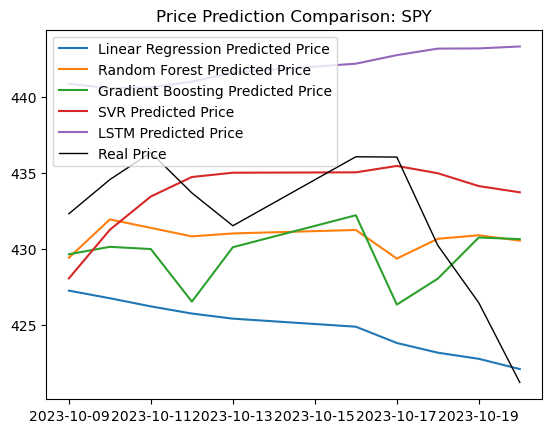

Target Price 1: 430.9092253231796, Target Price 2: 432.191042472263


In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def compute_rsi(data, window):
    """计算RSI"""
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

def compute_bollinger_bands(data, window):
    """计算Bollinger Bands"""
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = sma + (rolling_std*2)
    lower_band = sma - (rolling_std*2)
    return upper_band, lower_band

def create_dataset(dataset, look_back=1):
    """使用滑动窗口法创建数据集"""
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def get_data(ticker_symbol, start_date, end_date):
    """获取指定日期范围内的股票数据"""
    ticker_data = yf.Ticker(ticker_symbol)
    historical_data = ticker_data.history(start=start_date, end=end_date)
    return historical_data[['Close', 'Volume']].copy()

def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    """计算MAPE"""
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def evaluate_parameters(rsi_window, sma_window, bollinger_window):
    """评估指定的技术指标参数"""
    data = get_data(ticker_symbol, start_date, end_date)
    data['RSI'] = compute_rsi(data['Close'], rsi_window)
    data['SMA'] = data['Close'].rolling(window=sma_window).mean()
    data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, bollinger_window)
    data.dropna(inplace=True)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    look_back = 10
    X, y = create_dataset(data_scaled, look_back)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    model = LinearRegression()
    model.fit(X_train[:, -1, :], y_train)
    y_pred = model.predict(X_test[:, -1, :])
    y_real = y_test
    mape = mean_absolute_percentage_error(y_real, y_pred)
    return mape

# 下面是您的模型训练和预测部分。由于长度限制，我现在先停止。
# 接下来，我将继续整理并添加注释，然后进入您的新需求实现部分。
def train_models(X_train, y_train, X_test, y_test):
    """训练多个模型并返回"""
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=200, random_state=24),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=24),
        "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1),
        "LSTM": Sequential([
            LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
            Dropout(0.2),
            LSTM(50, return_sequences=True),
            Dropout(0.2),
            LSTM(25),
            Dense(1)
        ])
    }
    models["LSTM"].compile(optimizer='adam', loss='mean_squared_error')
    models["Linear Regression"].fit(X_train[:, -1, :], y_train)
    models["Random Forest"].fit(X_train[:, -1, :], y_train)
    models["Gradient Boosting"].fit(X_train[:, -1, :], y_train)
    models["SVR"].fit(X_train[:, -1, :], y_train)
    models["LSTM"].fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    
    return models

# ... [预测和评估部分]

def predict_next_10_days(models, data_scaled, look_back):
    """预测未来10天的股价"""
    # 使用最优模型进行预测
    best_model = models["Gradient Boosting"]  # 这里假设Gradient Boosting是最优模型，您可以根据之前的评估结果选择其它模型
    future_predictions = predict_future(best_model, data_scaled[-look_back:, :], 10, is_lstm=False)
    
    # 反归一化预测结果
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(future_predictions).reshape(-1, 1), np.zeros((len(future_predictions), data.shape[1]-1))]))[:, 0]
    return predicted_prices

def compute_target_prices(predicted_prices):
    """计算目标价格1和目标价格2"""
    target_price_2 = max(predicted_prices)
    target_price_1 = (predicted_prices[0] + target_price_2) / 2
    return target_price_1, target_price_2

# ... [主逻辑部分，其中调用上述函数来获取目标价格]

def evaluate_predictions(models, real_prices, data_scaled, look_back, num_points):
    """评估预测结果"""
    predictions = {}
    for model_name, model in models.items():
        if model_name == "LSTM":
            predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
        else:
            predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
        predicted_prices = scaler.inverse_transform(np.hstack([np.array(predictions[model_name]).reshape(-1, 1), np.zeros((len(predictions[model_name]), data.shape[1]-1))]))[:, 0]
        plt.plot(real_data.index[:num_points], predicted_prices, label=f'{model_name} Predicted Price')
    plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
    plt.legend()
    plt.title(f'Price Prediction Comparison: {ticker_symbol}')
    plt.show()

    return predictions
def predict_future(model, last_data, num_points, is_lstm=False):
    """使用模型预测未来的价格"""
    future_predictions = []
    
    # 使用最后的数据开始预测
    current_input = last_data.reshape(1, *last_data.shape)
    
    for i in range(num_points):
        if is_lstm:
            # 使用LSTM模型进行预测
            prediction = model.predict(current_input)[0, 0]
        else:
            # 使用其他模型进行预测
            prediction = model.predict(current_input[:, -1, :])[0]
        
        future_predictions.append(prediction)
        
        # 更新输入数据
        current_input = np.roll(current_input, -1, axis=1)
        current_input[0, -1, 0] = prediction

    return future_predictions
# 定义参数的范围
space  = [Integer(5, 30, name='rsi_window'),
          Integer(5, 30, name='sma_window'),
          Integer(5, 30, name='bollinger_window')]

# 使用贝叶斯优化搜索最优参数
@use_named_args(space)
def objective(**params):
    return evaluate_parameters(params['rsi_window'], params['sma_window'], params['bollinger_window'])

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_rsi_window = res_gp.x[0]
best_sma_window = res_gp.x[1]
best_bollinger_window = res_gp.x[2]

# ... [主逻辑部分]
if __name__ == "__main__":
    ticker_symbol = 'SPY'
    start_date = '2023-01-01'
    end_date = '2023-10-01'
    data = get_data(ticker_symbol, start_date, end_date)
    
    # 为数据添加技术指标
    data['RSI'] = compute_rsi(data['Close'], best_rsi_window)
    data['SMA'] = data['Close'].rolling(window=best_sma_window).mean()
    data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, best_bollinger_window)
    data.dropna(inplace=True)
    
    # 数据归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    # 使用滑动窗口法创建数据集
    look_back = 10
    X, y = create_dataset(data_scaled, look_back)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

    # 训练模型
    models = train_models(X_train, y_train, X_test, y_test)

    # 获取真实的股价数据
    real_data = get_data(ticker_symbol, '2023-10-09', datetime.today().strftime('%Y-%m-%d'))
    real_prices = real_data['Close'].values

    # 评估预测
    predictions = evaluate_predictions(models, real_prices, data_scaled, look_back, 10)

    # 预测未来10天的股价
    future_prices = predict_next_10_days(models, data_scaled, look_back)

    # 计算目标价格
    target_price_1, target_price_2 = compute_target_prices(future_prices)
    print(f"Target Price 1: {target_price_1}, Target Price 2: {target_price_2}")




In [16]:
def integrated_prediction(models, data_scaled, look_back, num_points):
    """结合各模型的预测结果进行整合预测"""
    slope_errors, difference_errors = evaluate_models_on_slope_and_difference(models, real_prices, data_scaled, look_back, num_points)
    
    # 根据斜率和差异排序模型
    best_slope_model = sorted(slope_errors, key=slope_errors.get)[0]
    best_difference_model = sorted(difference_errors, key=difference_errors.get)[0]

    # 获取两个模型的预测值
    if best_slope_model == "LSTM":
        slope_predictions = predict_future(models[best_slope_model], data_scaled[-look_back:, :], num_points, is_lstm=True)
    else:
        slope_predictions = predict_future(models[best_slope_model], data_scaled[-look_back:, :], num_points, is_lstm=False)

    if best_difference_model == "LSTM":
        difference_predictions = predict_future(models[best_difference_model], data_scaled[-look_back:, :], num_points, is_lstm=True)
    else:
        difference_predictions = predict_future(models[best_difference_model], data_scaled[-look_back:, :], num_points, is_lstm=False)

    # 结合两个模型的优势生成新的预测序列
    slope_adjustments = np.insert(compute_slope(np.array(difference_predictions)), 0, 0) 
    combined_predictions = np.array(difference_predictions) + slope_adjustments * slope_errors[best_slope_model]
    
    # 反归一化 combined_predictions
    combined_predictions_rescaled = scaler.inverse_transform(np.hstack([combined_predictions.reshape(-1, 1), np.zeros((len(combined_predictions), data.shape[1]-1))]))[:, 0]

    # 使用上述函数调整预测
    adjusted_predictions_scaled = adjust_predictions_based_on_max_changes(real_prices, combined_predictions_rescaled)

    # 反归一化调整后的预测
    adjusted_predictions_rescaled = scaler.inverse_transform(np.hstack([adjusted_predictions_scaled.reshape(-1, 1), np.zeros((len(adjusted_predictions_scaled), data.shape[1]-1))]))[:, 0]
    
    return adjusted_predictions_rescaled


In [13]:
if __name__ == "__main__":
    # ... [之前的部分，包括数据获取、添加技术指标、数据归一化、训练模型等]
    
    # 使用整合的预测方式预测未来10天的股价
    future_prices = integrated_prediction(models, data_scaled, look_back, 10)

    # 计算目标价格
    target_price_1, target_price_2 = compute_target_prices(future_prices)
    print(f"Target Price 1: {target_price_1}, Target Price 2: {target_price_2}")



NameError: name 'models' is not defined